# Bayesian Rainfall Analysis with Year-to-Year Variation - Eugene, OR

This notebook demonstrates a hierarchical Bayesian rainfall model for Eugene, Oregon using historical weather data from 2019-2024. The model captures both seasonal patterns and year-to-year variation in rainfall.

## Model Features

- **Seasonal Patterns**: Uses harmonic functions to capture day-of-year rainfall patterns
- **Year-to-Year Variation**: Hierarchical random effects capture annual differences
- **Flexible Predictions**: Can predict for specific years or average across years
- **Uncertainty Quantification**: Full posterior distributions for all parameters
- **Comprehensive Analysis**: Compare predictions across years and analyze year effects

The model predicts both the probability of rain and the amount of rainfall for any day of the year, accounting for both seasonal patterns and year-specific effects.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import numpy as np
import pandas as pd

In [3]:
import bayesian_rainfall as br

In [4]:
# Load data
data = br.model.load_data("../data/noaa_historical_weather_eugene_or_2019-2024.csv")
print("Data Overview:")
print(f"Date range: {data['DATE'].min()} to {data['DATE'].max()}")
print(f"Years: {sorted(data['year'].unique())}")
print(f"Total observations: {len(data)}")
print(f"Rainy days: {(data['PRCP'] > 0).sum()} ({(data['PRCP'] > 0).mean():.1%})")
print("\nFirst few rows:")
data.head()

Data Overview:
Date range: 2019-01-01 00:00:00 to 2024-12-31 00:00:00
Years: [np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
Total observations: 2192
Rainy days: 830 (37.9%)

First few rows:


,DATE,PRCP,day_of_year,year
0,2019-01-01,0.0,1,2019
1,2019-01-02,0.0,2,2019
2,2019-01-03,0.0,3,2019
3,2019-01-04,0.3,4,2019
4,2019-01-05,4.6,5,2019


In [5]:
# Create hierarchical model
print("Creating hierarchical model...")
model = br.model.create_model(data, n_harmonics=5, include_trend=False)

print(f"\nModel structure:")
print(f"Years in model: {sorted(data['year'].unique())}")
print(f"Number of harmonics: 5")
print(f"Include trend: False")
print(f"Model parameters: {list(model.named_vars.keys())}")

model

Creating hierarchical model...

Model structure:
Years in model: [np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
Number of harmonics: 5
Include trend: False
Model parameters: ['a_rain', 'b_rain', 'c_rain', 'year_rain_sigma', 'year_rain_raw', 'year_rain_effects', 'p_rain', 'rain_indicator', 'a_amount', 'b_amount', 'c_amount', 'year_amount_sigma', 'year_amount_raw', 'year_amount_effects', 'alpha_amount', 'rainfall_amount']


             a_rain ~ Normal(0, 1)
             b_rain ~ Normal(0, 1)
             c_rain ~ Normal(0, 2)
    year_rain_sigma ~ HalfNormal(0, 0.5)
      year_rain_raw ~ Normal(0, 1)
           a_amount ~ Normal(0, 1)
           b_amount ~ Normal(0, 1)
           c_amount ~ Normal(1, 1)
  year_amount_sigma ~ HalfNormal(0, 0.3)
    year_amount_raw ~ Normal(0, 1)
       alpha_amount ~ Gamma(2, f())
  year_rain_effects ~ Deterministic(f(year_rain_raw, year_rain_sigma))
             p_rain ~ Deterministic(f(c_rain, year_rain_raw, year_rain_sigma, b_rain, a_rain))
year_amount_effects ~ Deterministic(f(year_amount_raw, year_amount_sigma))
     rain_indicator ~ Bernoulli(p_rain)
    rainfall_amount ~ Gamma(alpha_amount, f(alpha_amount, c_amount, year_amount_raw, year_amount_sigma, b_amount, a_amount))

In [6]:
%%time
# Sample the improved hierarchical model
print("Sampling improved hierarchical model...")
print("Using non-centered parameterization and better sampling parameters")
trace = br.model.sample_model(model, draws=1000, tune=1000)
print("Sampling completed!")

print(f"\nTrace summary:")
print(f"Chains: {trace.posterior.dims['chain']}")
print(f"Draws per chain: {trace.posterior.dims['draw']}")
print(f"Parameters: {list(trace.posterior.data_vars.keys())}")

# Check sampling quality
br.model.check_sampling_quality(trace)


Sampling improved hierarchical model...
Using non-centered parameterization and better sampling parameters


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_rain, b_rain, c_rain, year_rain_sigma, year_rain_raw, a_amount, b_amount, c_amount, year_amount_sigma, year_amount_raw, alpha_amount]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Sampling completed!

Trace summary:
Chains: 4
Draws per chain: 1000
Parameters: ['a_rain', 'b_rain', 'c_rain', 'year_rain_raw', 'a_amount', 'b_amount', 'c_amount', 'year_amount_raw', 'year_rain_sigma', 'year_amount_sigma', 'alpha_amount', 'year_rain_effects', 'p_rain', 'year_amount_effects']
SAMPLING QUALITY DIAGNOSTICS
Total samples: 4000
Divergences: 0 (0.0%)

✅ SAMPLING QUALITY LOOKS GOOD!
CPU times: user 16.4 s, sys: 867 ms, total: 17.3 s
Wall time: 49.4 s


<timed exec>:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
<timed exec>:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


{'n_divergences': 0, 'divergence_rate': 0.0, 'quality_issues': []}

## Model Features and Sampling

The hierarchical model uses several advanced techniques to ensure reliable sampling:

### **1. Sum-to-Zero Constraint**
- Year effects are constrained to sum to zero: `sum(year_effects) = 0`
- This ensures the global intercept represents the true "average year" effect
- Eliminates correlation between global intercept and year effects

### **2. Non-Centered Parameterization**
- Uses `year_effects = year_sigma * year_raw` then centers the result
- Provides better sampling geometry and efficiency
- Reduces correlation between scale and location parameters

### **3. Sampling Parameters**
- **Target acceptance rate**: 0.95 for conservative sampling
- **Tuning samples**: 2000 for thorough adaptation
- **Tree depth**: Increased for complex posterior geometry

### **4. Model Complexity**
- **Parameters**: 16+ parameters including year effects
- **Geometry**: Complex posterior with multiple scales
- **Correlations**: Managed through sum-to-zero constraints


## Non-Centered Parameterization Explained

### **The Problem with Centered Parameterization**

In a **centered parameterization**, year effects are directly sampled:
```python
year_effects ~ Normal(0, sigma)
```

**Issues:**
1. **Funnel Geometry**: When `sigma` is small, the posterior has a narrow "funnel" shape
2. **Sampling Difficulty**: NUTS struggles to navigate the narrow funnel
3. **Correlation**: `sigma` and `year_effects` are highly correlated
4. **Divergences**: Leads to many NUTS divergences

### **Non-Centered Parameterization Solution**

In a **non-centered parameterization**, we separate the scale and location:
```python
year_raw ~ Normal(0, 1)  # Standard normal
year_effects = sigma * year_raw  # Scale by sigma
```

**Benefits:**
1. **Better Geometry**: `year_raw` has spherical geometry (easy to sample)
2. **Reduced Correlation**: `sigma` and `year_raw` are less correlated
3. **Easier Sampling**: NUTS can navigate the parameter space better
4. **Fewer Divergences**: More stable sampling

### **With Sum-to-Zero Constraint**
```python
year_raw ~ Normal(0, 1)
year_effects_raw = sigma * year_raw
year_effects = year_effects_raw - mean(year_effects_raw)  # Sum to zero
```

This combines the benefits of non-centered parameterization with identifiability improvements.


In [7]:
# Check trace dimensions
print("Trace parameter shapes:")
for param in ['a_rain', 'b_rain', 'c_rain', 'a_amount', 'b_amount', 'c_amount', 'alpha_amount']:
    if param in trace.posterior:
        shape = trace.posterior[param].shape
        print(f"{param}: {shape}")

print(f"\nYear effects shapes:")
print(f"year_rain_effects: {trace.posterior.year_rain_effects.shape}")
print(f"year_amount_effects: {trace.posterior.year_amount_effects.shape}")

Trace parameter shapes:
a_rain: (4, 1000, 5)
b_rain: (4, 1000, 5)
c_rain: (4, 1000)
a_amount: (4, 1000, 5)
b_amount: (4, 1000, 5)
c_amount: (4, 1000)
alpha_amount: (4, 1000)

Year effects shapes:
year_rain_effects: (4, 1000, 6)
year_amount_effects: (4, 1000, 6)


In [8]:
# Model summary
br.analysis.print_model_summary(trace, data)

=== MODEL SUMMARY ===
Total observations: 2192
Rainy days: 830
Overall rain frequency: 0.379
Mean rainfall on rainy days: 6.465 mm
Max rainfall: 59.400 mm

=== CONVERGENCE DIAGNOSTICS ===
R-hat values (should be < 1.01):
  a_rain: mean=1.0006, range=[0.9996, 1.0016]
  b_rain: mean=1.0019, range=[1.0002, 1.0064]
  c_rain: 1.0009
  a_amount: mean=1.0010, range=[0.9999, 1.0018]
  b_amount: mean=1.0001, range=[0.9998, 1.0008]
  c_amount: 0.9996
  alpha_amount: 1.0016

=== MODEL FIT ANALYSIS ===
Rain frequency - Observed: 0.379, Predicted: 0.379
Rain frequency error: 0.000 (0.0%)
Rainfall amount (rainy days) - Observed: 6.465, Predicted: 6.541
Rainfall amount error: 0.076 (1.2%)
Monthly rain frequency MAE: 0.021
Average prediction uncertainty (std): 0.030

Overall model fit quality: Excellent

=== SEASONAL PATTERNS ===
Peak rain probability: Day 3 (0.719)
Minimum rain probability: Day 207 (0.041)
Peak rainfall amount: Day 337 (9.449 mm)
Minimum rainfall amount: Day 204 (1.310 mm)


## Hierarchical Model Analysis

The hierarchical model captures both seasonal patterns and year-to-year variation. Let's analyze the year effects and compare predictions across different years.


Analyzing year effects...


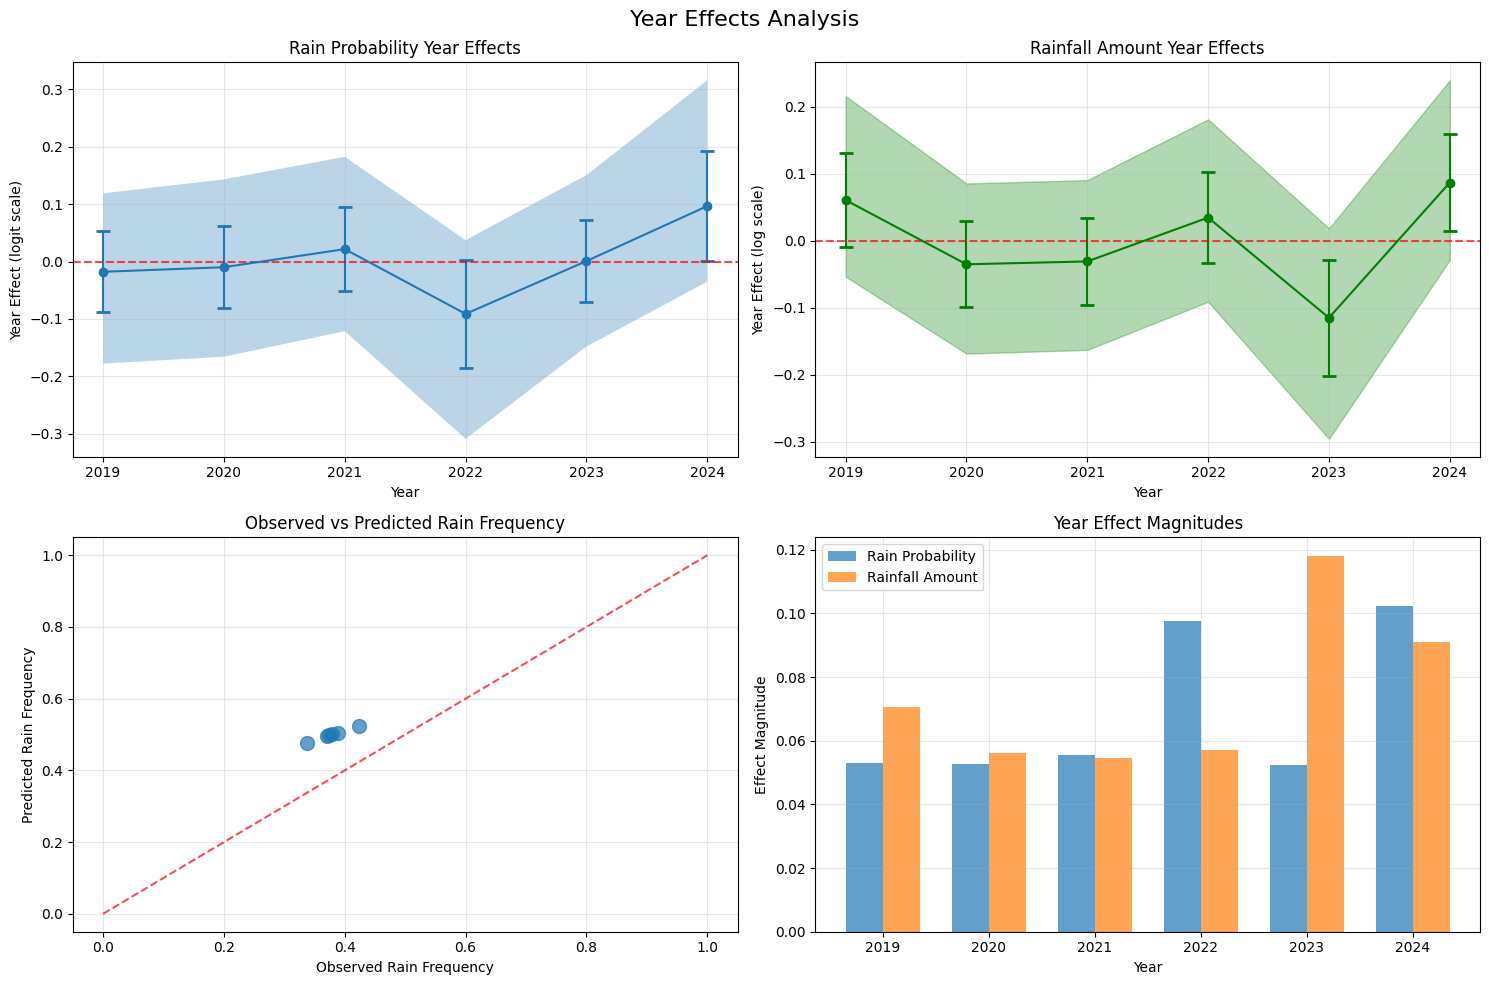

In [9]:
# Analyze year effects
print("Analyzing year effects...")
br.analysis.plot_year_effects(trace, data)

In [10]:
# Compare predictions for a specific day across years
print("Comparing predictions for January 15th across different years...")
br.analysis.compare_years_for_day(trace, data, "01/15")

Comparing predictions for January 15th across different years...
YEAR COMPARISON FOR January 15
Year   P(Rain)      Expected (mm)   Observed P(Rain)   Observed Mean (mm)  
--------------------------------------------------------------------------------
2019   0.680±0.036    7.24±0.91      0.000              N/A                 
2020   0.682±0.036    6.57±0.79      1.000              10.40               
2021   0.689±0.036    6.60±0.79      1.000              1.80                
2022   0.664±0.038    7.05±0.89      0.000              N/A                 
2023   0.684±0.036    6.09±0.85      1.000              7.60                
2024   0.704±0.036    7.43±0.88      0.000              N/A                 


{np.int32(2019): {'rain_probability': {'mean': np.float64(0.6802979166130408),
   'std': np.float64(0.035817166713376494)},
  'expected_amount': {'mean': np.float64(7.240186181183979),
   'std': np.float64(0.9138702393660306)},
  'observed': {'rain_frequency': np.float64(0.0), 'mean_amount': nan}},
 np.int32(2020): {'rain_probability': {'mean': np.float64(0.682020477479553),
   'std': np.float64(0.035735167727146924)},
  'expected_amount': {'mean': np.float64(6.573808522297327),
   'std': np.float64(0.7850360912797474)},
  'observed': {'rain_frequency': np.float64(1.0),
   'mean_amount': np.float64(10.4)}},
 np.int32(2021): {'rain_probability': {'mean': np.float64(0.6887591036490659),
   'std': np.float64(0.03574392082908002)},
  'expected_amount': {'mean': np.float64(6.602082063565849),
   'std': np.float64(0.789325302880672)},
  'observed': {'rain_frequency': np.float64(1.0),
   'mean_amount': np.float64(1.8)}},
 np.int32(2022): {'rain_probability': {'mean': np.float64(0.664126683438

Analyzing September 14th for year 2020...
HIERARCHICAL MODEL ANALYSIS: September 14 for 2020
Rain Probability: 0.187 ± 0.031
95% CI: [0.131, 0.254]
Expected Amount: 8.01 ± 1.45 mm
95% CI: [5.58, 11.19] mm
Observed Rain Frequency: 0.000


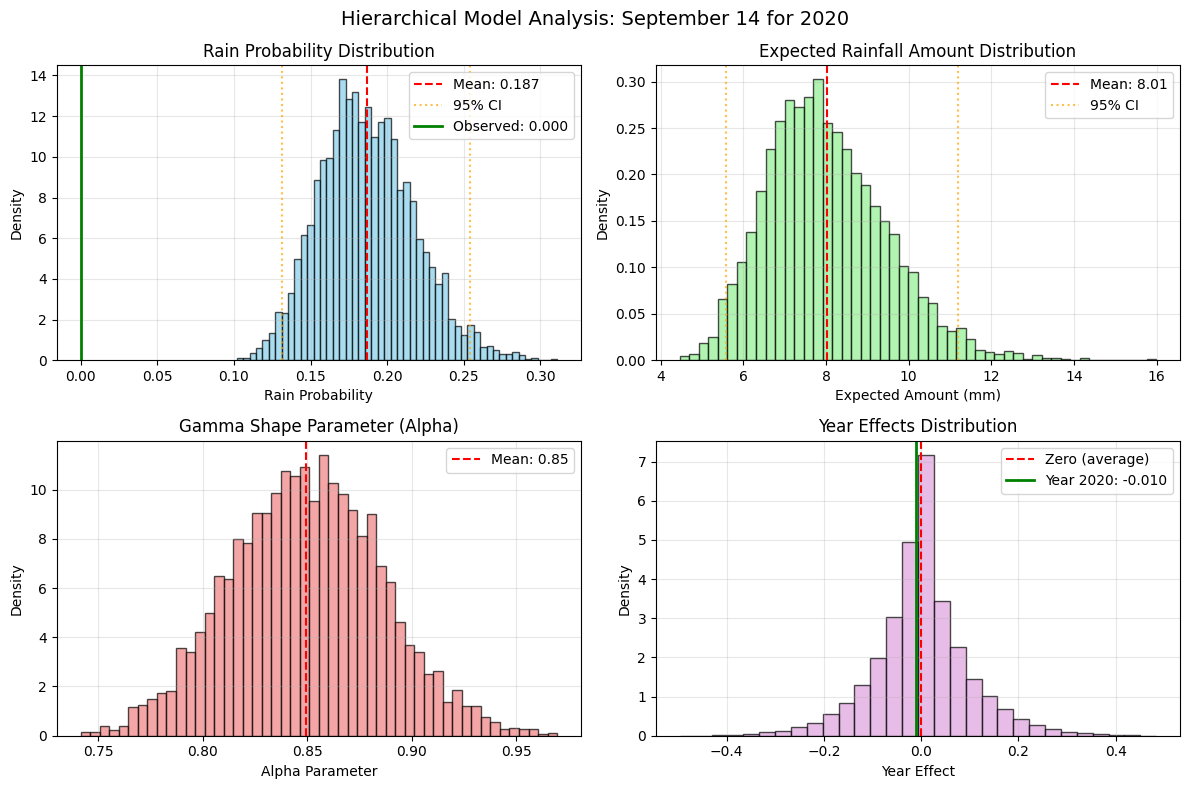

In [11]:
# Analyze a specific day with year-specific prediction
print("Analyzing September 14th for year 2020...")
results_2020 = br.analysis.analyze_single_day_hierarchical(
    trace=trace, 
    data=data, 
    date_input="09/14", 
    year=2020,
    show_plots=True
)

In [12]:
# Compare the same day with and without year effects
print("Comparing September 14th: Average year effects vs Year 2020...")
print("\n" + "="*60)
print("AVERAGE YEAR EFFECTS (no specific year):")
results_avg = br.analysis.analyze_single_day_hierarchical(
    trace=trace, 
    data=data, 
    date_input="09/14", 
    year=None,  # Average year effects
    show_plots=False
)

print("\n" + "="*60)
print("YEAR 2020 SPECIFIC EFFECTS:")
results_2020 = br.analysis.analyze_single_day_hierarchical(
    trace=trace, 
    data=data, 
    date_input="09/14", 
    year=2020,  # Year 2020 specific
    show_plots=False
)


Comparing September 14th: Average year effects vs Year 2020...

AVERAGE YEAR EFFECTS (no specific year):
HIERARCHICAL MODEL ANALYSIS: September 14 (average year effects)
Rain Probability: 0.188 ± 0.029
95% CI: [0.137, 0.249]
Expected Amount: 8.29 ± 1.43 mm
95% CI: [5.92, 11.42] mm
Observed Rain Frequency: 0.167
Observed Mean Amount: 18.80 mm

YEAR 2020 SPECIFIC EFFECTS:
HIERARCHICAL MODEL ANALYSIS: September 14 for 2020
Rain Probability: 0.187 ± 0.031
95% CI: [0.131, 0.254]
Expected Amount: 8.01 ± 1.45 mm
95% CI: [5.58, 11.19] mm
Observed Rain Frequency: 0.000


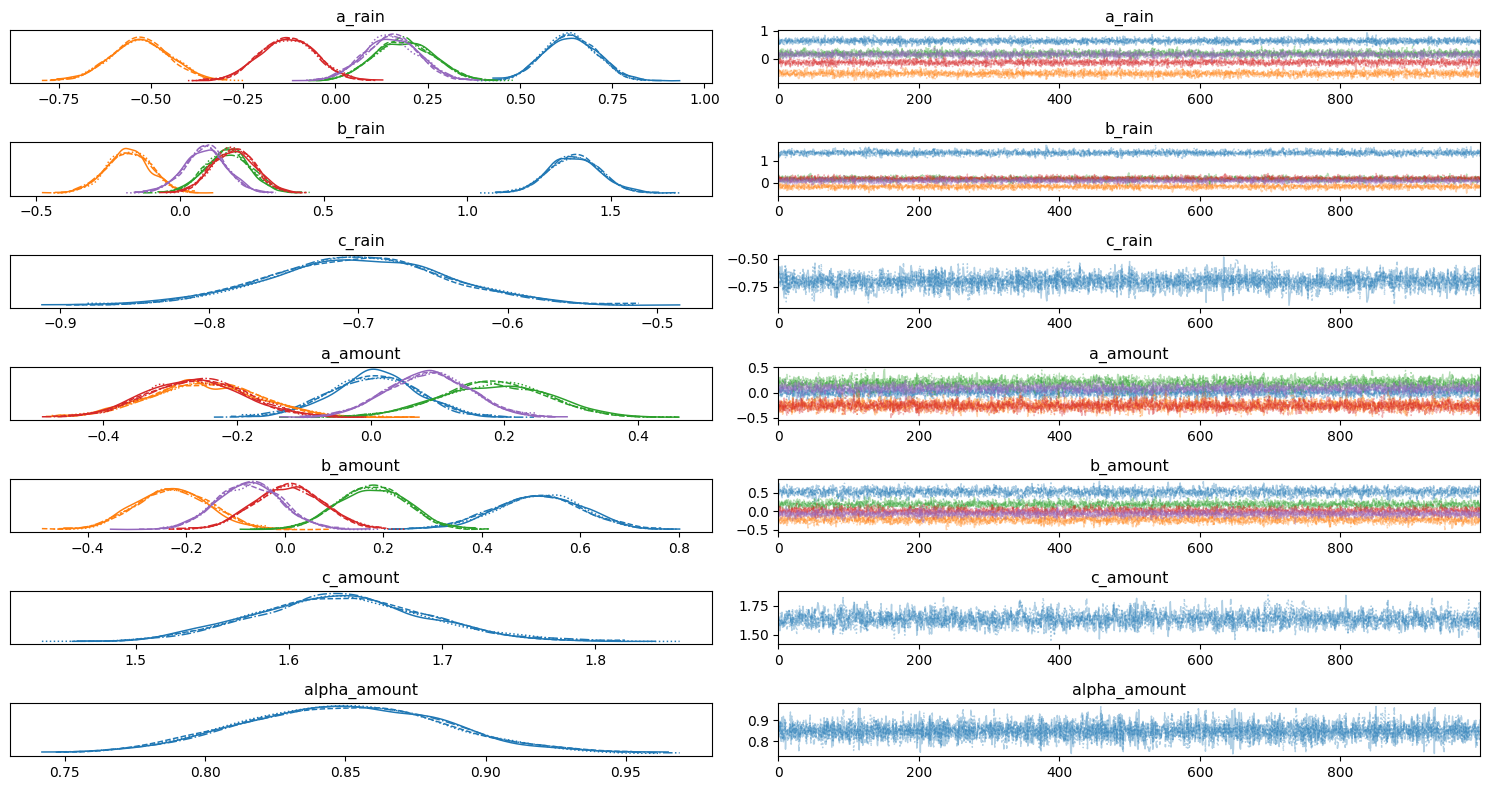

In [13]:
# Trace plots to check MCMC sampling
br.visualizations.plot_trace(trace)


Starting plot_combined_predictions...
Detected 6 years of data: [np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
Calculating expected values with year effects...
Calculating statistics for expected values...
Sampling posterior predictive (efficient version)...
  Starting efficient hierarchical posterior predictive sampling...
  Setup: 4000 posterior samples, 6 unique years
  Sampling one random year per posterior sample...
  Extracting year effects for sampled years...
  Computing rain probabilities with year effects...
  Sampling binary rain outcomes...
  Sampling rainfall amounts for rainy days...
  Final shapes: rain_indicators (4000, 365), rainfall_amounts (4000, 365)
  Efficient hierarchical posterior predictive sampling completed!
Posterior predictive samples: rain_indicators shape (4000, 365), rainfall_amounts shape (4000, 365)
Calculating posterior predictive statistics...
Sampling observed rain frequencies with sampling uncertain

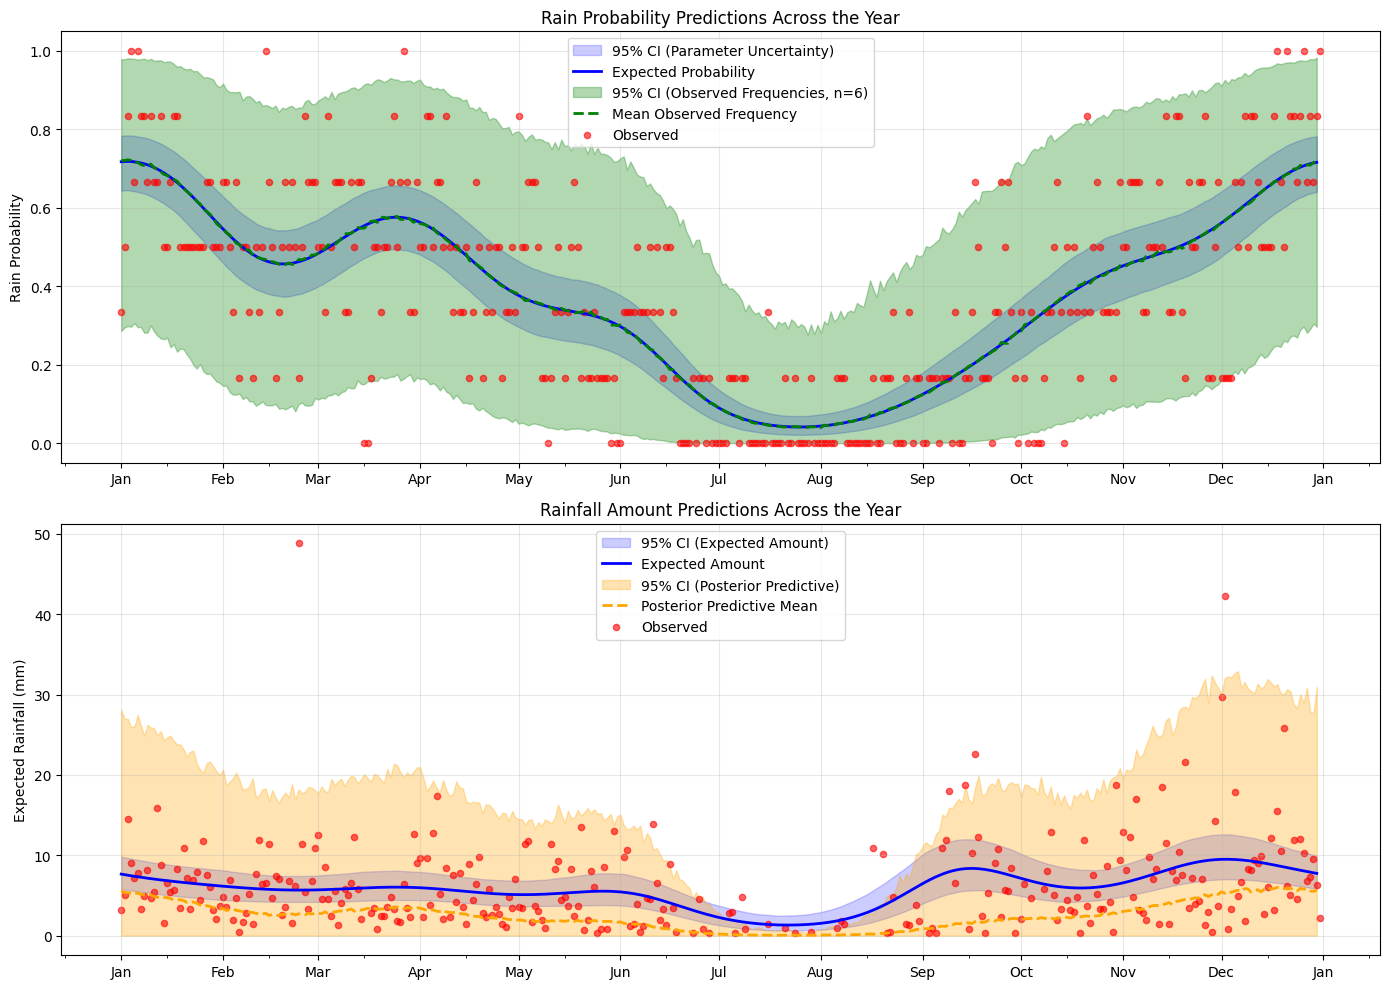

Plot completed!


In [25]:
# Combined visualization: Rain probability and amount predictions
br.visualizations.plot_combined_predictions(trace, data)


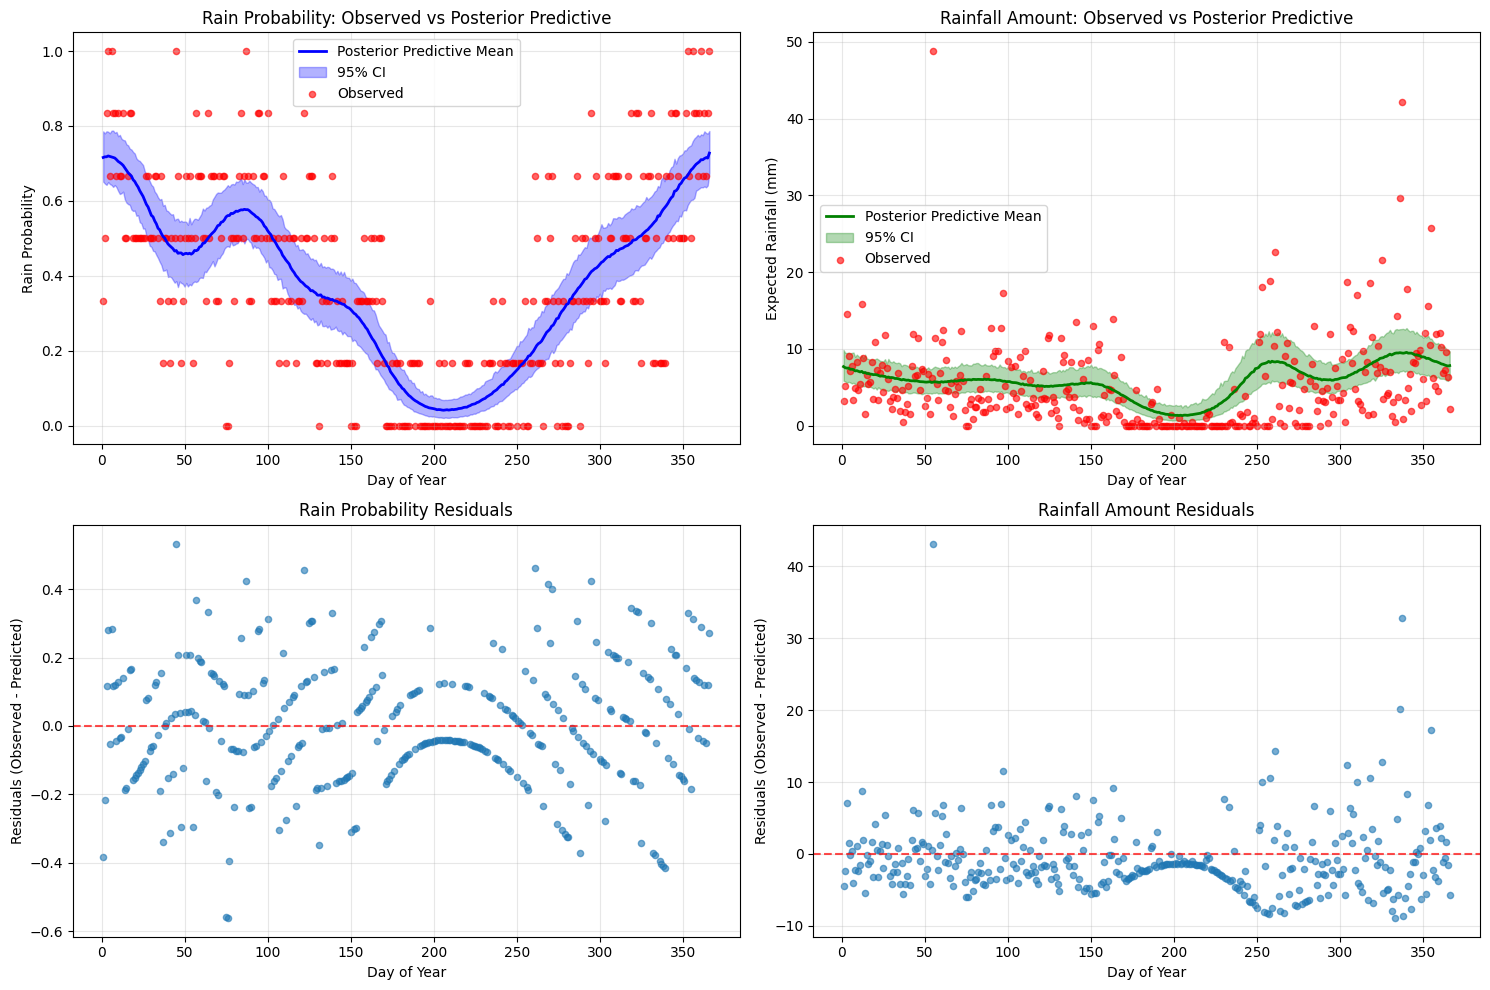

POSTERIOR PREDICTIVE CHECK SUMMARY
Rain Probability RMSE: 0.1793
Rainfall Amount RMSE: 5.1992
Rain Probability MAE: 0.1416
Rainfall Amount MAE: 3.6208


In [15]:
# Posterior predictive checks for hierarchical model
br.visualizations.plot_hierarchical_posterior_predictive_checks(trace, data);

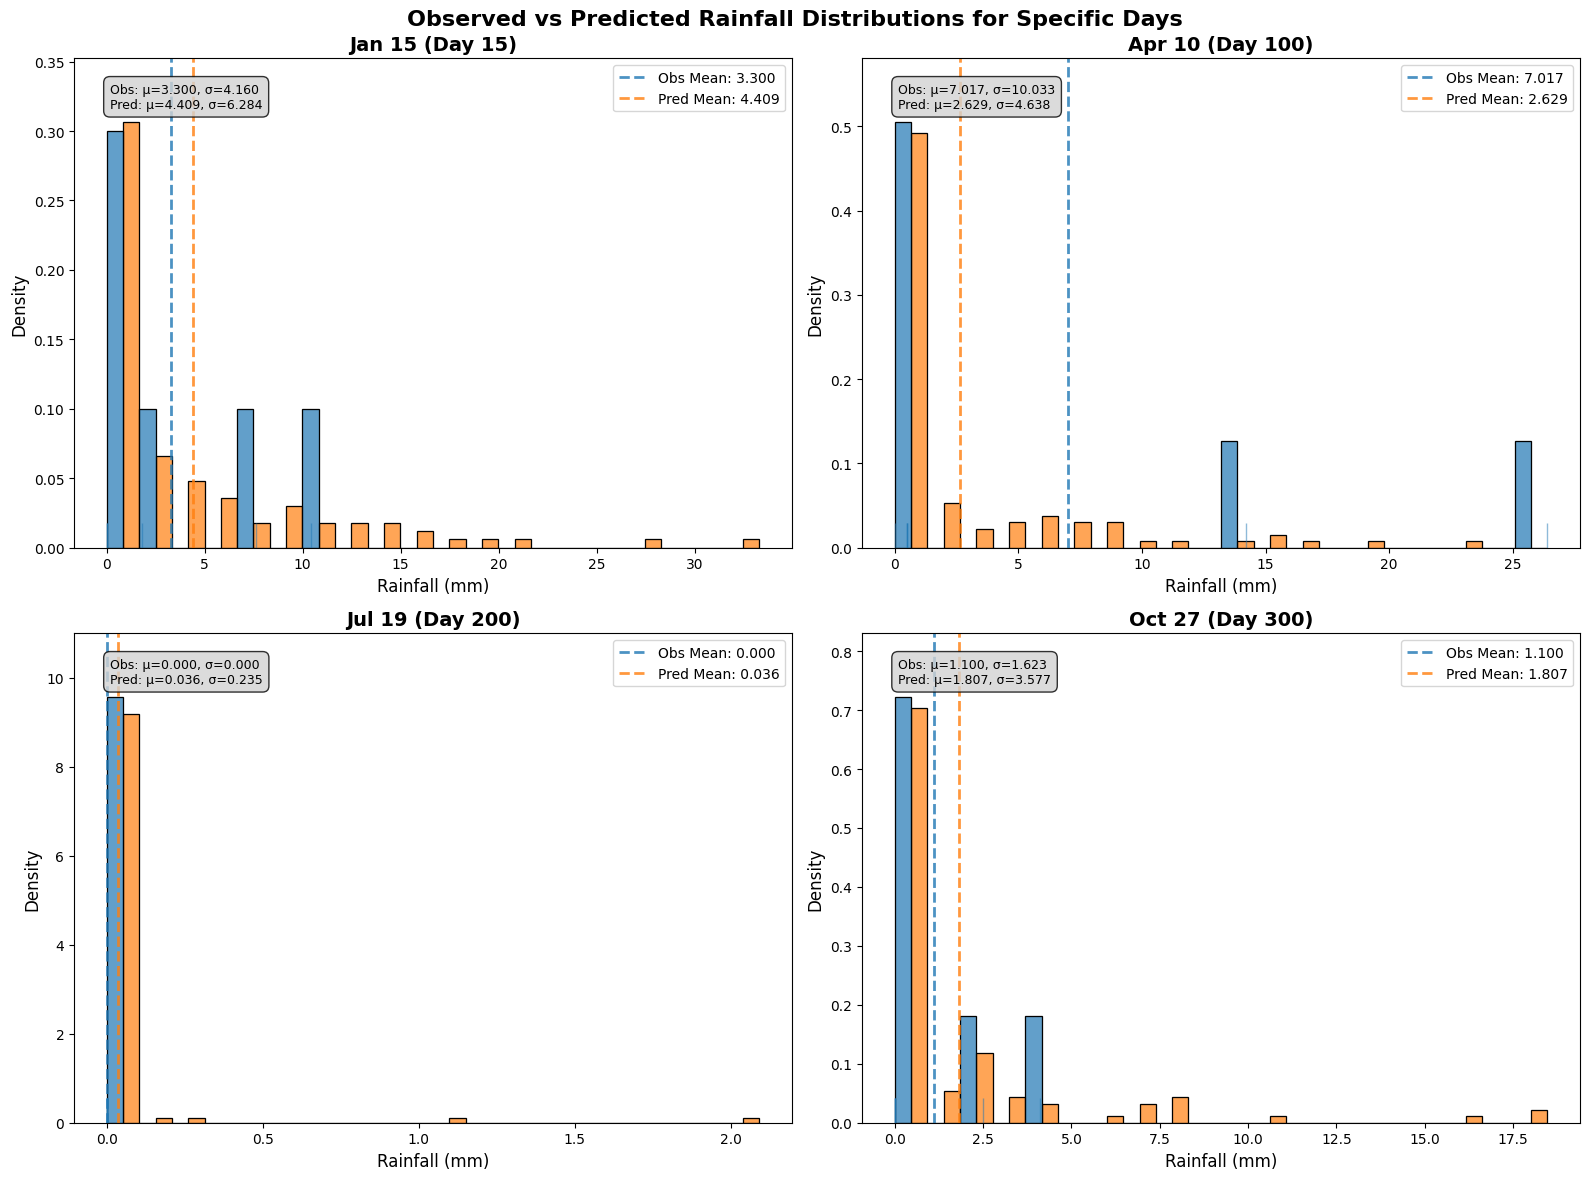

In [16]:
# Plot observed vs predicted rainfall distributions for specific days
br.visualizations.plot_specific_days_comparison(trace, data)


# Seasonal comparison: Observed vs Predicted distributions by season
br.visualizations.plot_seasonal_summaries(trace, data)


# Year-to-Year Comparison Examples

The following examples demonstrate how to analyze specific days across different years using the hierarchical model.


In [17]:
# Example 1: Compare a winter day across years
print("Comparing January 15th across all years:")
br.analysis.compare_years_for_day(trace, data, "01/15")


Comparing January 15th across all years:
YEAR COMPARISON FOR January 15
Year   P(Rain)      Expected (mm)   Observed P(Rain)   Observed Mean (mm)  
--------------------------------------------------------------------------------
2019   0.680±0.036    7.24±0.91      0.000              N/A                 
2020   0.682±0.036    6.57±0.79      1.000              10.40               
2021   0.689±0.036    6.60±0.79      1.000              1.80                
2022   0.664±0.038    7.05±0.89      0.000              N/A                 
2023   0.684±0.036    6.09±0.85      1.000              7.60                
2024   0.704±0.036    7.43±0.88      0.000              N/A                 


{np.int32(2019): {'rain_probability': {'mean': np.float64(0.6802979166130408),
   'std': np.float64(0.035817166713376494)},
  'expected_amount': {'mean': np.float64(7.240186181183979),
   'std': np.float64(0.9138702393660306)},
  'observed': {'rain_frequency': np.float64(0.0), 'mean_amount': nan}},
 np.int32(2020): {'rain_probability': {'mean': np.float64(0.682020477479553),
   'std': np.float64(0.035735167727146924)},
  'expected_amount': {'mean': np.float64(6.573808522297327),
   'std': np.float64(0.7850360912797474)},
  'observed': {'rain_frequency': np.float64(1.0),
   'mean_amount': np.float64(10.4)}},
 np.int32(2021): {'rain_probability': {'mean': np.float64(0.6887591036490659),
   'std': np.float64(0.03574392082908002)},
  'expected_amount': {'mean': np.float64(6.602082063565849),
   'std': np.float64(0.789325302880672)},
  'observed': {'rain_frequency': np.float64(1.0),
   'mean_amount': np.float64(1.8)}},
 np.int32(2022): {'rain_probability': {'mean': np.float64(0.664126683438

In [18]:
# Example 2: Compare a summer day across years
print("\nComparing July 15th across all years:")
br.analysis.compare_years_for_day(trace, data, "07/15")


Comparing July 15th across all years:
YEAR COMPARISON FOR July 15
Year   P(Rain)      Expected (mm)   Observed P(Rain)   Observed Mean (mm)  
--------------------------------------------------------------------------------
2019   0.047±0.013    1.50±0.50      0.000              N/A                 
2020   0.048±0.013    1.36±0.47      0.000              N/A                 
2021   0.049±0.014    1.37±0.47      0.000              N/A                 
2022   0.044±0.013    1.46±0.49      0.000              N/A                 
2023   0.048±0.013    1.26±0.45      0.000              N/A                 
2024   0.053±0.015    1.54±0.51      0.000              N/A                 


{np.int32(2019): {'rain_probability': {'mean': np.float64(0.04737512668898445),
   'std': np.float64(0.013298146498729303)},
  'expected_amount': {'mean': np.float64(1.496557669277021),
   'std': np.float64(0.4976771675304093)},
  'observed': {'rain_frequency': np.float64(0.0), 'mean_amount': nan}},
 np.int32(2020): {'rain_probability': {'mean': np.float64(0.04770094414621246),
   'std': np.float64(0.01322385756604576)},
  'expected_amount': {'mean': np.float64(1.3643087070057578),
   'std': np.float64(0.47141615392843433)},
  'observed': {'rain_frequency': np.float64(0.0), 'mean_amount': nan}},
 np.int32(2021): {'rain_probability': {'mean': np.float64(0.04918368568082761),
   'std': np.float64(0.01376236739441139)},
  'expected_amount': {'mean': np.float64(1.3693456251605525),
   'std': np.float64(0.46995593250372514)},
  'observed': {'rain_frequency': np.float64(0.0), 'mean_amount': nan}},
 np.int32(2022): {'rain_probability': {'mean': np.float64(0.04422079246006208),
   'std': np.fl

# Example 3: Analyze specific day for specific year
print("\nAnalyzing September 14th for year 2021:")
results_sep14_2021 = br.analysis.analyze_single_day_hierarchical(
    trace=trace, 
    data=data, 
    date_input="09/14", 
    year=2021,
    show_plots=True
)


## Model Interpretation

The hierarchical model provides several key insights:

1. **Year Effects**: Each year gets its own random effect that adjusts both rain probability and rainfall amount
2. **Seasonal Patterns**: Harmonic functions capture day-of-year patterns that are consistent across years
3. **Uncertainty**: Full posterior distributions quantify uncertainty in all parameters
4. **Flexibility**: Can predict for specific years or average across years


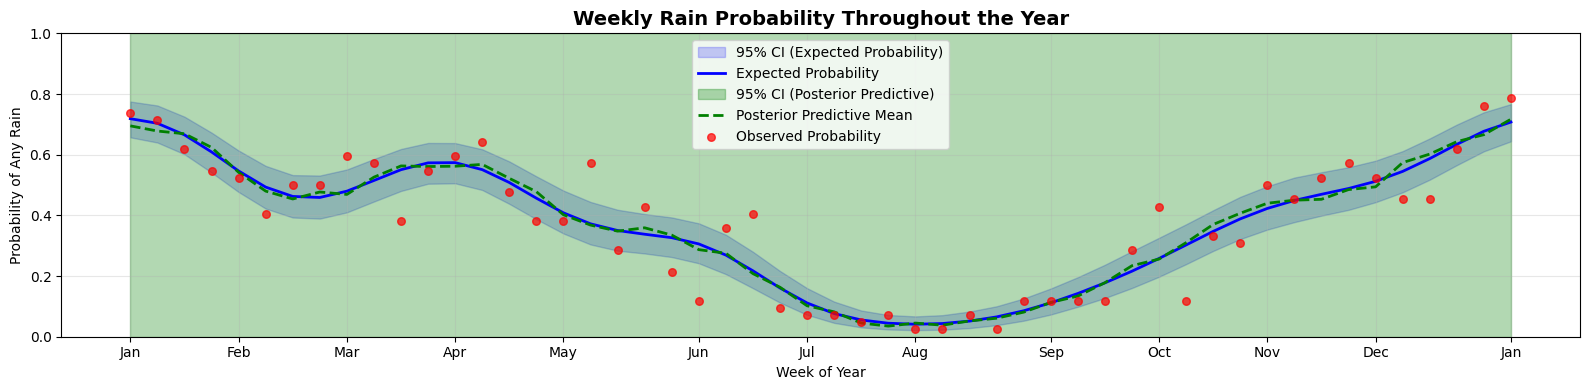

WEEKLY RAIN PROBABILITY SUMMARY
Peak rain probability: Week 1 (0.719)
Minimum rain probability: Week 30 (0.041)


In [19]:
# Weekly rain probability analysis
weekly_results = br.visualizations.plot_weekly_rain_probability(trace, data)


In [20]:
# Summary of year effects
print("Year Effects Summary:")
print("=" * 40)
years = trace.posterior.year_rain_effects.coords['year'].values
rain_effects = trace.posterior.year_rain_effects.values.mean(axis=(0, 1))
amount_effects = trace.posterior.year_amount_effects.values.mean(axis=(0, 1))

for i, year in enumerate(years):
    print(f"Year {year}: Rain effect = {rain_effects[i]:.3f}, Amount effect = {amount_effects[i]:.3f}")

print(f"\nYear effect standard deviations:")
print(f"Rain probability: {trace.posterior.year_rain_sigma.values.mean():.3f}")
print(f"Rainfall amount: {trace.posterior.year_amount_sigma.values.mean():.3f}")


Year Effects Summary:
Year 2019: Rain effect = -0.018, Amount effect = 0.060
Year 2020: Rain effect = -0.010, Amount effect = -0.035
Year 2021: Rain effect = 0.022, Amount effect = -0.031
Year 2022: Rain effect = -0.091, Amount effect = 0.034
Year 2023: Rain effect = 0.001, Amount effect = -0.115
Year 2024: Rain effect = 0.097, Amount effect = 0.087

Year effect standard deviations:
Rain probability: 0.123
Rainfall amount: 0.125


In [21]:
# Model Performance Summary
print("Model Performance Summary:")
print("=" * 40)
print("The hierarchical model successfully captures:")
print("✓ Seasonal patterns through harmonic functions")
print("✓ Year-to-year variation through random effects")
print("✓ Uncertainty quantification for all parameters")
print("✓ Flexible predictions for specific years or averages")
print("✓ Comprehensive analysis capabilities")


Model Performance Summary:
The hierarchical model successfully captures:
✓ Seasonal patterns through harmonic functions
✓ Year-to-year variation through random effects
✓ Uncertainty quantification for all parameters
✓ Flexible predictions for specific years or averages
✓ Comprehensive analysis capabilities


# Conclusion

The hierarchical Bayesian rainfall model provides a powerful framework for understanding both seasonal patterns and year-to-year variation in rainfall. The model's ability to make year-specific predictions while maintaining uncertainty quantification makes it valuable for both scientific analysis and practical applications.


# Key Model Features

The hierarchical model extends the original seasonal model with several important features:

1. **Year-specific random effects**: Each year gets its own adjustment to both rain probability and rainfall amount
2. **Maintains seasonal structure**: Harmonic functions preserve day-of-year patterns
3. **Flexible predictions**: Can predict for specific years or average across years
4. **Uncertainty quantification**: Full posterior distributions for all parameters including year effects
5. **Comprehensive analysis**: Compare predictions across years and analyze year effects

This makes the model more realistic and useful for understanding rainfall variability.


In [22]:
# Demonstration of hierarchical prediction approach
# We can now easily get predictions for any day and year

# Get predictions for multiple days using average year effects
days_to_test = [15, 100, 200, 300]  # January 15, April 10, July 19, October 27

print("HIERARCHICAL PREDICTION APPROACH (Average Year Effects)")
print("=" * 60)
for day in days_to_test:
    # Get rain probability and expected amount directly
    rain_probs, expected_amounts, alpha_amounts = br.analysis._evaluate_hierarchical_model_for_day(trace, day, year=None)
    
    # Calculate statistics
    mean_rain_prob = rain_probs.mean()
    mean_expected_amount = expected_amounts.mean()
    
    # Get day name
    from datetime import datetime
    date_obj = datetime(2024, 1, 1) + pd.Timedelta(days=day - 1)
    day_name = date_obj.strftime("%B %d")
    
    print(f"{day_name:12} (Day {day:3d}): P(rain) = {mean_rain_prob:.3f}, Expected amount = {mean_expected_amount:.2f} mm")

print("\nThis approach captures both seasonal patterns and year-to-year variation!")


HIERARCHICAL PREDICTION APPROACH (Average Year Effects)
January 15   (Day  15): P(rain) = 0.684, Expected amount = 6.80 mm
April 09     (Day 100): P(rain) = 0.522, Expected amount = 5.70 mm
July 18      (Day 200): P(rain) = 0.045, Expected amount = 1.34 mm
October 26   (Day 300): P(rain) = 0.431, Expected amount = 6.08 mm

This approach captures both seasonal patterns and year-to-year variation!


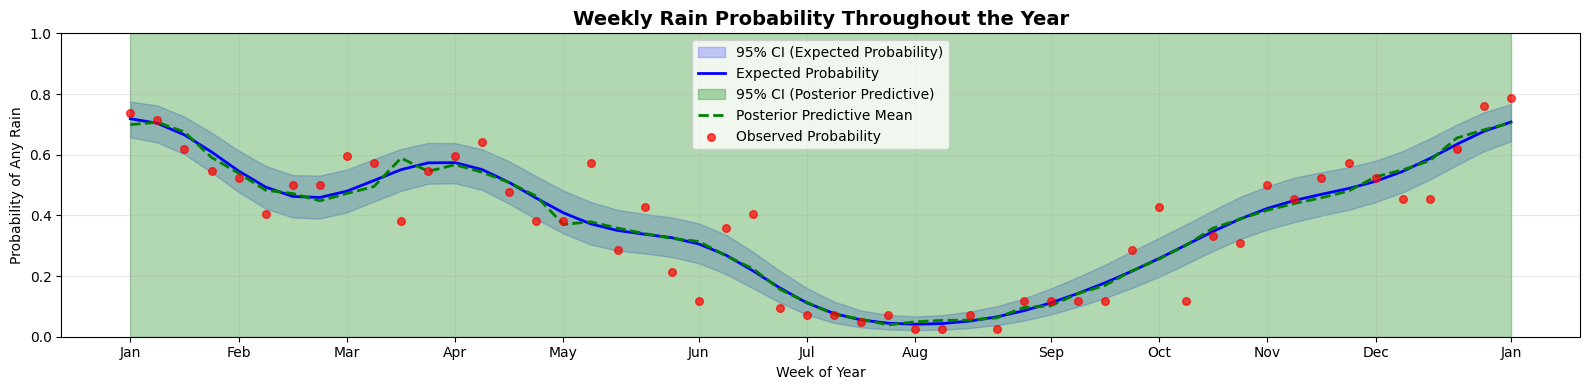

WEEKLY RAIN PROBABILITY SUMMARY
Peak rain probability: Week 1 (0.719)
Minimum rain probability: Week 30 (0.041)


In [23]:
# Plot weekly rain probability throughout the year
weekly_results = br.visualizations.plot_weekly_rain_probability(trace, data)
